In [5]:
!pip uninstall tensorflow -y
!pip install tensorflow==2.15.1 --force-reinstall
# Ensure tensorflow-intel is not installed as it can cause conflicts
!pip uninstall tensorflow-intel -y
# Install compatible versions of numpy and pandas after TensorFlow installation
!pip install numpy==1.26.4 pandas==2.1.4 --force-reinstall

Found existing installation: tensorflow 2.15.1
Uninstalling tensorflow-2.15.1:
  Successfully uninstalled tensorflow-2.15.1
  Using cached tensorflow-2.15.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.2 kB)
  Using cached ml_dtypes-0.3.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (20 kB)
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached protobuf-4.25.8-cp37-abi3-manylinux2014_x86_64.whl.metadata (541 bytes)
  Using cached wrapt-1.14.1-cp311-cp311-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.7 kB)
  Using cached tensorboard-2.15.2-py3-none-any.whl.metadata (1.7 kB)
  Using cached tensorflow_estimator-2.15.0-py2.py3-none-any.whl.metadata (1.3 kB)
  Using cached keras-2.15.0-py3-none-any.whl.metadata (2.4 kB)
Using cached tensorflow-2.15.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (475.3 MB)
   ━━━━━━

  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached pandas-2.1.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (18 kB)
  Using cached six-1.17.0-py2.py3-none-any.whl.metadata (1.7 kB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
Using cached pandas-2.1.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.2 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.9/229.9 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 509.2/509.2 kB 35.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.8/347.8 kB 27.7 MB/s eta 0:00:00
Using cached six-1.17.0-py2.py3-none-any.whl (11 kB)
  Attempting uninstall: pytz
    Found existing installation: pytz 2025.2
    Uninstalling pytz-2025.2:
      Successfully uninstalled pytz-2025.2
  Attempting uninstall: tzdata
    Found existing installation: tzdata 2025.2
    Uninstalling

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_v2_preprocess_input
import matplotlib.pyplot as plt
import os
import zipfile
import random
from PIL import Image

In [2]:
from google.colab import files
if not os.path.exists('/root/.kaggle/kaggle.json'):
    print("Please upload your kaggle.json API token.")
    files.upload()
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json
else:
    print("Kaggle API token already exists.")

if not os.path.exists('./spoof_data'):
    os.makedirs('./spoof_data')

!kaggle datasets download -dciplab/real-and-fake-face-detection -p ./spoof_data --unzip
print("Dataset download attempted.")

Please upload your kaggle.json API token.


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/ciplab/real-and-fake-face-detection
License(s): CC-BY-NC-SA-4.0
 89% 383M/431M [00:00<00:00, 445MB/s]
100% 431M/431M [00:00<00:00, 479MB/s]
Dataset download attempted.


In [3]:
dataset_base_dir = './spoof_data/real_and_fake_face_detection/real_and_fake_face/'

train_real_dir = os.path.join(dataset_base_dir, 'training_real')
train_fake_dir = os.path.join(dataset_base_dir, 'training_fake')

all_files = []
labels = []

if not os.path.exists(train_real_dir) or not os.path.exists(train_fake_dir):
    print(f"ERROR: Training directories not found. Please verify the dataset_base_dir: {dataset_base_dir}")
else:
    print(f"Training real images path: {train_real_dir}")
    print(f"Training fake images path: {train_fake_dir}")
    train_real_files = [os.path.join(train_real_dir, f) for f in os.listdir(train_real_dir) if os.path.isfile(os.path.join(train_real_dir, f))]
    train_fake_files = [os.path.join(train_fake_dir, f) for f in os.listdir(train_fake_dir) if os.path.isfile(os.path.join(train_fake_dir, f))]
    print(f"Number of real training images: {len(train_real_files)}")
    print(f"Number of fake training images: {len(train_fake_files)}")
    all_files = train_real_files + train_fake_files
    labels = [1] * len(train_real_files) + [0] * len(train_fake_files)
    if not all_files:
        print("No image files found after checking paths.")
    else:
        print(f"Total training images found: {len(all_files)}")

Training real images path: ./spoof_data/real_and_fake_face_detection/real_and_fake_face/training_real
Training fake images path: ./spoof_data/real_and_fake_face_detection/real_and_fake_face/training_fake
Number of real training images: 1081
Number of fake training images: 960
Total training images found: 2041


In [4]:
img_width, img_height = 160, 160
images_data = []
processed_labels = []
X_train, X_val, y_train, y_val = np.array([]), np.array([]), np.array([]), np.array([])

if all_files:
    for i, file_path in enumerate(all_files):
        try:
            img = Image.open(file_path).convert('RGB')
            img = img.resize((img_width, img_height))
            img_array = mobilenet_v2_preprocess_input(np.array(img))
            images_data.append(img_array)
            processed_labels.append(labels[i])
        except Exception as e:
            print(f"Error processing image {file_path}: {e}")

    if images_data:
        images_data = np.array(images_data)
        processed_labels = np.array(processed_labels)
        print(f"Processed images shape: {images_data.shape}")
        print(f"Processed labels shape: {processed_labels.shape}")
        X_train, X_val, y_train, y_val = train_test_split(
            images_data, processed_labels, test_size=0.2, random_state=42, stratify=processed_labels
        )
        print(f"Training samples: {X_train.shape[0]}, labels: {y_train.shape[0]}")
        print(f"Validation samples: {X_val.shape[0]}, labels: {y_val.shape[0]}")
    else:
        print("No images were successfully processed.")
else:
    print("Skipping image processing and splitting as no files were initially found.")

Processed images shape: (2041, 160, 160, 3)
Processed labels shape: (2041,)
Training samples: 1632, labels: 1632
Validation samples: 409, labels: 409


In [5]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D

spoof_model = None
if X_train.size > 0:
    def create_spoof_model_mobilenetv2(input_shape, learning_rate=0.001):
        base_model_mobilenet = MobileNetV2(input_shape=input_shape,
                                           include_top=False,
                                           weights='imagenet')
        base_model_mobilenet.trainable = False

        model = Sequential([
            base_model_mobilenet,
            GlobalAveragePooling2D(),
            Dense(128, activation='relu'),
            BatchNormalization(),
            Dropout(0.5),
            Dense(1, activation='sigmoid')
        ])

        model.compile(optimizer=Adam(learning_rate=learning_rate),
                      loss='binary_crossentropy',
                      metrics=['accuracy'])
        return model

    input_shape_spoof = (img_width, img_height, 3)
    spoof_model = create_spoof_model_mobilenetv2(input_shape_spoof)
    spoof_model.summary()
else:
    print("Skipping model definition as training data is empty.")

9406464/9406464 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 batch_normalization (Batch  (None, 128)               512       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 128)               0   

In [6]:
train_datagen_spoof = None
val_datagen_spoof = None
if X_train.size > 0:
    train_datagen_spoof = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.15,
        height_shift_range=0.15,
        shear_range=0.15,
        zoom_range=0.15,
        horizontal_flip=True,
        brightness_range=[0.8, 1.2],
        fill_mode='nearest'
    )
    val_datagen_spoof = ImageDataGenerator()
    print("Data augmenters defined.")
else:
    print("Skipping data augmentation setup as training data is empty.")

Data augmenters defined.


In [7]:
batch_size_spoof = 32
epochs_spoof = 75
early_stopping_spoof = None
reduce_lr_spoof = None
model_checkpoint_path_spoof = 'spoof_detection_mobilenet_head_best.keras'
checkpoint_spoof = None

if X_train.size > 0:
    early_stopping_spoof = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
    reduce_lr_spoof = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5, verbose=1)
    checkpoint_spoof = ModelCheckpoint(
        filepath=model_checkpoint_path_spoof,
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )
    print(f"Batch size: {batch_size_spoof}, Epochs for head training: {epochs_spoof}")
else:
    print("Skipping training parameters setup as training data is empty.")

Batch size: 32, Epochs for head training: 75


Starting spoof model head training with data augmentation...
Epoch 1/75
51/51 [==============================] - ETA: 0s - loss: 0.8748 - accuracy: 0.5349
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to spoof_detection_mobilenet_head_best.keras
51/51 [==============================] - 45s 790ms/step - loss: 0.8748 - accuracy: 0.5349 - val_loss: 0.9444 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/75
51/51 [==============================] - ETA: 0s - loss: 0.7572 - accuracy: 0.5882
Epoch 2: val_accuracy improved from 0.50000 to 0.62500, saving model to spoof_detection_mobilenet_head_best.keras
51/51 [==============================] - 38s 752ms/step - loss: 0.7572 - accuracy: 0.5882 - val_loss: 0.6915 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 3/75
51/51 [==============================] - ETA: 0s - loss: 0.7043 - accuracy: 0.6183
Epoch 3: val_accuracy did not improve from 0.62500
51/51 [==============================] - 43s 850ms/step - loss: 0.7043 - accuracy: 0.6183 -

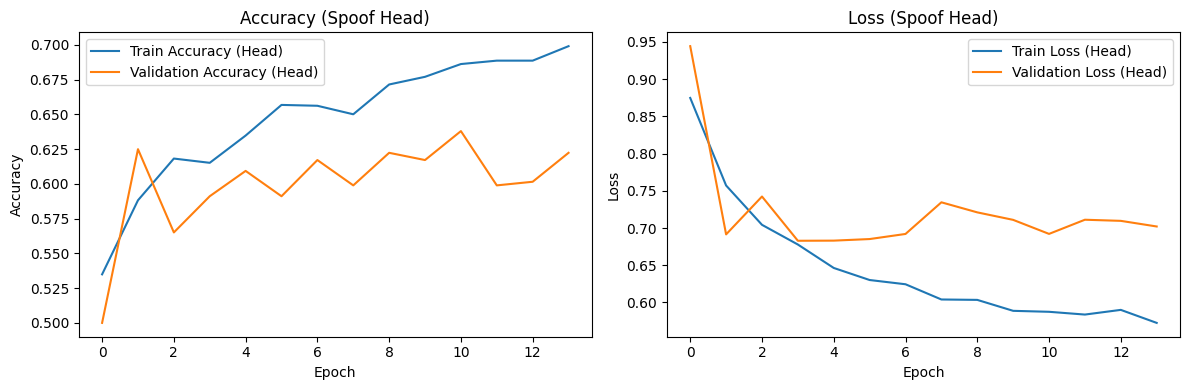

In [8]:
history_spoof_head = None
if spoof_model and X_train.size > 0 and train_datagen_spoof and val_datagen_spoof and checkpoint_spoof and reduce_lr_spoof and early_stopping_spoof:
    print("Starting spoof model head training with data augmentation...")
    history_spoof_head = spoof_model.fit(
        train_datagen_spoof.flow(X_train, y_train, batch_size=batch_size_spoof),
        steps_per_epoch=len(X_train) // batch_size_spoof if len(X_train) >= batch_size_spoof else 1,
        epochs=epochs_spoof,
        validation_data=val_datagen_spoof.flow(X_val, y_val, batch_size=batch_size_spoof),
        validation_steps=len(X_val) // batch_size_spoof if len(X_val) >= batch_size_spoof else 1,
        callbacks=[early_stopping_spoof, reduce_lr_spoof, checkpoint_spoof],
        verbose=1
    )
    print("Spoof model head training finished.")

    if history_spoof_head:
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(history_spoof_head.history['accuracy'], label='Train Accuracy (Head)')
        plt.plot(history_spoof_head.history['val_accuracy'], label='Validation Accuracy (Head)')
        plt.legend()
        plt.title('Accuracy (Spoof Head)')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.subplot(1, 2, 2)
        plt.plot(history_spoof_head.history['loss'], label='Train Loss (Head)')
        plt.plot(history_spoof_head.history['val_loss'], label='Validation Loss (Head)')
        plt.legend()
        plt.title('Loss (Spoof Head)')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.tight_layout()
        plt.show()
else:
    print("Skipping model head training as model or data or callbacks are not available.")

In [9]:
loaded_head_model = None
if os.path.exists(model_checkpoint_path_spoof):
    print("Loading the best head-trained spoof model...")
    loaded_head_model = load_model(model_checkpoint_path_spoof)
    print(f"Model '{model_checkpoint_path_spoof}' loaded successfully.")
elif spoof_model and history_spoof_head:
    print(f"Warning: Checkpoint file '{model_checkpoint_path_spoof}' not found. Using model from end of head training.")
    loaded_head_model = spoof_model
else:
    print("No head-trained spoof model found to load.")

if loaded_head_model and X_val.size > 0:
    print("Evaluating head-trained spoof model on the validation set...")
    loss_head, accuracy_head = loaded_head_model.evaluate(X_val, y_val, batch_size=batch_size_spoof, verbose=0)
    print(f'Head-trained Validation Loss (Spoof): {loss_head:.4f}')
    print(f'Head-trained Validation Accuracy (Spoof): {accuracy_head*100:.2f}%')
else:
    print("Skipping head-trained model evaluation as model or validation data is not available.")

Loading the best head-trained spoof model...
Model 'spoof_detection_mobilenet_head_best.keras' loaded successfully.
Evaluating head-trained spoof model on the validation set...
Head-trained Validation Loss (Spoof): 0.7048
Head-trained Validation Accuracy (Spoof): 62.59%


In [10]:
if loaded_head_model:
    base_model_to_finetune = loaded_head_model.layers[0]
    base_model_to_finetune.trainable = True


    loaded_head_model.compile(optimizer=Adam(learning_rate=1e-5),
                               loss='binary_crossentropy',
                               metrics=['accuracy'])

    print("MobileNetV2 base model layers are now trainable.")
    print("Model recompiled for fine-tuning with a very low learning rate.")
    loaded_head_model.summary()
else:
    print("No loaded_head_model found to set up for fine-tuning.")

MobileNetV2 base model layers are now trainable.
Model recompiled for fine-tuning with a very low learning rate.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 batch_normalization (Batch  (None, 128)               512       
 Normalization)                                                  
                                                                 
 dropout 

Starting MobileNetV2 fine-tuning for 30 epochs...
Epoch 1/30
51/51 [==============================] - ETA: 0s - loss: 0.7633 - accuracy: 0.5938
Epoch 1: val_accuracy improved from -inf to 0.61719, saving model to spoof_detection_mobilenet_finetuned_best.keras
51/51 [==============================] - 156s 3s/step - loss: 0.7633 - accuracy: 0.5938 - val_loss: 0.7185 - val_accuracy: 0.6172 - lr: 1.0000e-05
Epoch 2/30
51/51 [==============================] - ETA: 0s - loss: 0.7281 - accuracy: 0.5980
Epoch 2: val_accuracy did not improve from 0.61719
51/51 [==============================] - 141s 3s/step - loss: 0.7281 - accuracy: 0.5980 - val_loss: 0.7230 - val_accuracy: 0.6120 - lr: 1.0000e-05
Epoch 3/30
51/51 [==============================] - ETA: 0s - loss: 0.6868 - accuracy: 0.6238
Epoch 3: val_accuracy did not improve from 0.61719
51/51 [==============================] - 140s 3s/step - loss: 0.6868 - accuracy: 0.6238 - val_loss: 0.7299 - val_accuracy: 0.6120 - lr: 1.0000e-05
Epoch 4/3

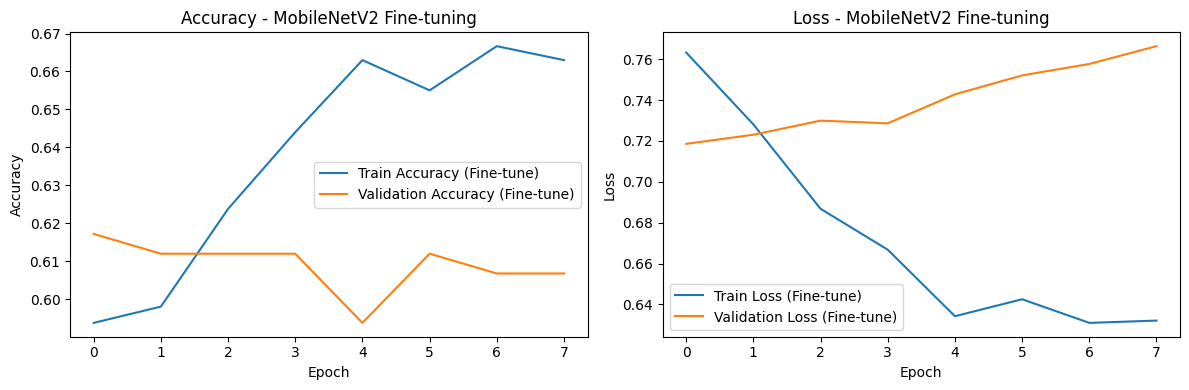

In [11]:
history_fine_tune = None
if loaded_head_model and X_train.size > 0:
    fine_tune_epochs = 30

    model_checkpoint_path_finetune = 'spoof_detection_mobilenet_finetuned_best.keras'

    checkpoint_finetune = ModelCheckpoint(
        filepath=model_checkpoint_path_finetune,
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )

    reduce_lr_finetune = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=1e-7,
        verbose=1
    )

    early_stopping_finetune = EarlyStopping(
        monitor='val_loss',
        patience=7,
        restore_best_weights=True,
        verbose=1
    )

    print(f"Starting MobileNetV2 fine-tuning for {fine_tune_epochs} epochs...")


    history_fine_tune = loaded_head_model.fit(
        train_datagen_spoof.flow(X_train, y_train, batch_size=batch_size_spoof),
        steps_per_epoch=len(X_train) // batch_size_spoof if len(X_train) >= batch_size_spoof else 1,
        epochs=fine_tune_epochs,
        validation_data=val_datagen_spoof.flow(X_val, y_val, batch_size=batch_size_spoof),
        validation_steps=len(X_val) // batch_size_spoof if len(X_val) >= batch_size_spoof else 1,
        callbacks=[early_stopping_finetune, reduce_lr_finetune, checkpoint_finetune]
    )
    print("MobileNetV2 fine-tuning finished.")

    if history_fine_tune:
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(history_fine_tune.history['accuracy'], label='Train Accuracy (Fine-tune)')
        plt.plot(history_fine_tune.history['val_accuracy'], label='Validation Accuracy (Fine-tune)')
        plt.legend()
        plt.title('Accuracy - MobileNetV2 Fine-tuning')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')

        plt.subplot(1, 2, 2)
        plt.plot(history_fine_tune.history['loss'], label='Train Loss (Fine-tune)')
        plt.plot(history_fine_tune.history['val_loss'], label='Validation Loss (Fine-tune)')
        plt.legend()
        plt.title('Loss - MobileNetV2 Fine-tuning')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.tight_layout()
        plt.show()
else:
    print("Skipping MobileNetV2 fine-tuning as the head-trained model or training data is not available.")

In [12]:
loaded_finetuned_model = None
if os.path.exists(model_checkpoint_path_finetune):
    print("Loading the best fine-tuned MobileNetV2 model...")
    loaded_finetuned_model = load_model(model_checkpoint_path_finetune)
    print(f"Model '{model_checkpoint_path_finetune}' loaded successfully.")
elif history_fine_tune:
    print(f"Warning: Best fine-tuned model file '{model_checkpoint_path_finetune}' not found.")
    print("Using model state from the end of the fine-tuning process (which might not be the best if EarlyStopping restored weights to a point before the final epoch).")
    loaded_finetuned_model = loaded_head_model
else:
    print("No fine-tuned MobileNetV2 model checkpoint found and no fine-tuning history available.")

if loaded_finetuned_model and X_val.size > 0:
    print("Evaluating fine-tuned MobileNetV2 model on the validation set...")
    loss_ft, accuracy_ft = loaded_finetuned_model.evaluate(X_val, y_val, batch_size=batch_size_spoof, verbose=0)
    print(f'Fine-tuned MobileNetV2 Validation Loss (Spoof): {loss_ft:.4f}')
    print(f'Fine-tuned MobileNetV2 Validation Accuracy (Spoof): {accuracy_ft*100:.2f}%')
else:
    print("Skipping fine-tuned MobileNetV2 model evaluation as model or validation data is not available.")

Loading the best fine-tuned MobileNetV2 model...
Model 'spoof_detection_mobilenet_finetuned_best.keras' loaded successfully.
Evaluating fine-tuned MobileNetV2 model on the validation set...
Fine-tuned MobileNetV2 Validation Loss (Spoof): 0.7122
Fine-tuned MobileNetV2 Validation Accuracy (Spoof): 62.59%



Displaying 5 sample spoof predictions from the validation set (using fine-tuned model):


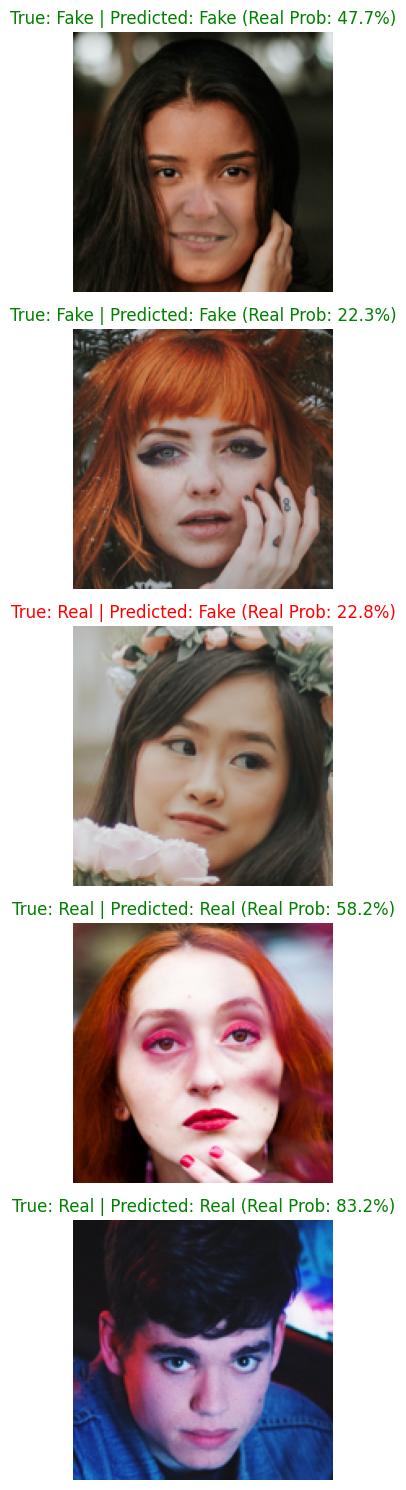

In [13]:
def predict_spoof_from_image_array(model_to_use, image_array_preprocessed, true_label_int):
    image_data_expanded = np.expand_dims(image_array_preprocessed, axis=0)
    prediction_prob = model_to_use.predict(image_data_expanded, verbose=0)[0][0]
    predicted_label_str = "Real" if prediction_prob > 0.5 else "Fake"
    true_label_str = "Real" if true_label_int == 1 else "Fake"
    return predicted_label_str, true_label_str, prediction_prob

if loaded_finetuned_model and X_val.size > 0:
    num_predictions_to_show = 5
    plt.figure(figsize=(15, 3 * num_predictions_to_show))
    print(f"\nDisplaying {num_predictions_to_show} sample spoof predictions from the validation set (using fine-tuned model):")
    for i in range(num_predictions_to_show):
        idx = np.random.randint(0, X_val.shape[0])
        sample_image_array = X_val[idx]
        sample_true_label_int = y_val[idx]

        display_image_array = (sample_image_array + 1) / 2.0
        display_image_array = np.clip(display_image_array, 0, 1)


        pred_label, true_label, pred_conf = predict_spoof_from_image_array(loaded_finetuned_model, sample_image_array, sample_true_label_int)
        plt.subplot(num_predictions_to_show, 1, i + 1)
        plt.imshow(display_image_array)
        title_color = 'green' if pred_label == true_label else 'red'
        plt.title(f"True: {true_label} | Predicted: {pred_label} (Real Prob: {pred_conf*100:.1f}%)", color=title_color)
        plt.axis('off')
    plt.tight_layout()
    plt.show()
else:
    print("Skipping inference visualization as fine-tuned model or data is not available.")



In [14]:

original_spoof_keras_path = 'spoof_detection_mobilenet_finetuned_best.keras'
new_spoof_h5_path = 'spoof_detection_mobilenet_finetuned_best.h5'

if not os.path.exists(original_spoof_keras_path):
    print(f"ERROR: Original spoof model file not found at '{original_spoof_keras_path}'")
    print("Please make sure the .keras spoof model file is present in your Colab session.")
else:
    try:

        model = tf.keras.models.load_model(original_spoof_keras_path, compile=False)
        print(f"Successfully loaded '{original_spoof_keras_path}'")

        model.save(new_spoof_h5_path, save_format='h5')
        print(f"Spoof model successfully re-saved to '{new_spoof_h5_path}'")
        print("You can now download this .h5 file from the Colab file browser (left sidebar).")

    except Exception as e:
        print(f"Error during spoof model re-saving process: {e}")
        print("Ensure the original .keras spoof model file is not corrupted.")

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Successfully loaded 'spoof_detection_mobilenet_finetuned_best.keras'
Spoof model successfully re-saved to 'spoof_detection_mobilenet_finetuned_best.h5'
You can now download this .h5 file from the Colab file browser (left sidebar).
